### Packages loading

In [21]:
import sys
sys.path.insert(0, '..')
import numpy as np
import random
import qiskit
import qtm.evolution
import qtm.state
import qtm.qcompilation
import qtm.ansatz
import qtm.constant
from qtm.evolution import environment, mutate, selection, crossover, utils
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Quantum architecture search for quantum state preparation problem

Now, we defind the problem which is need to solve

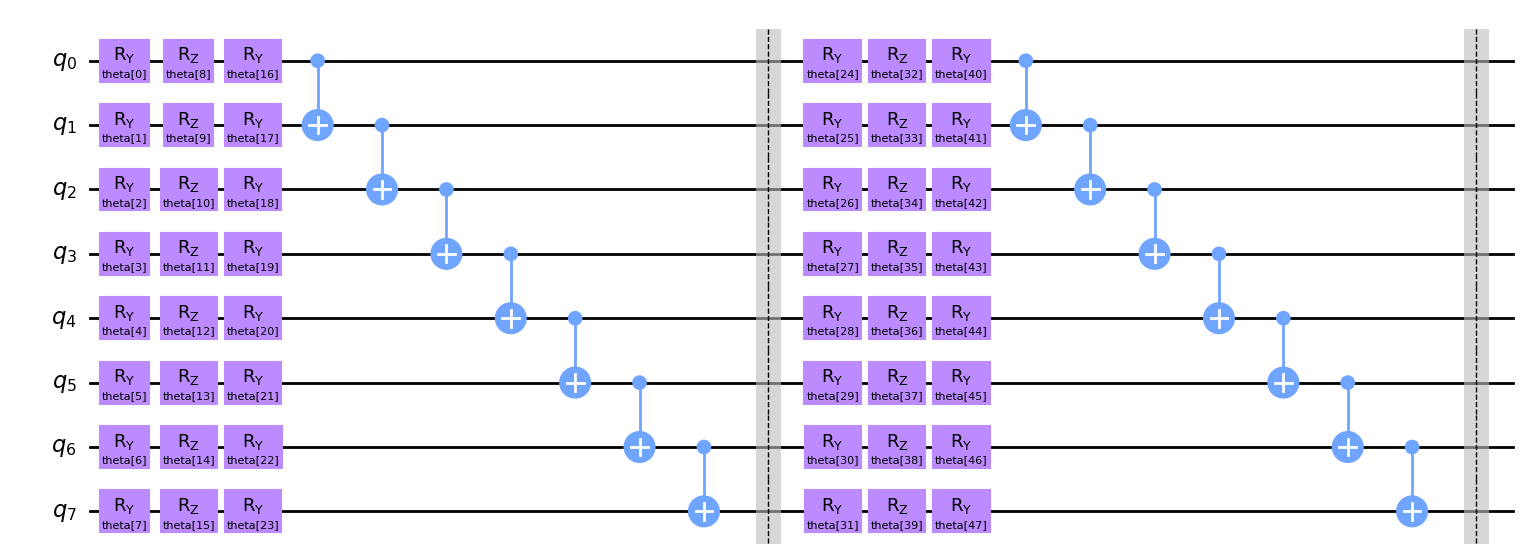

In [29]:
n_qubits=8
n=3
theta = qiskit.circuit.ParameterVector('theta',2*n*n_qubits)
#theta = np.random.rand(n*n_qubits)
#print(theta)
qc = qiskit.QuantumCircuit(n_qubits)
for i in range(n_qubits):
    qc.ry(theta[i], i)
for i in range(n_qubits):
    qc.rz(theta[i+n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+2*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

for i in range(n_qubits):
    qc.ry(theta[i+3*n_qubits], i)
for i in range(n_qubits):
    qc.rz(theta[i+4*n_qubits], i)
for i in range(n_qubits):
    qc.ry(theta[i+5*n_qubits], i)

for i in range(n_qubits-1):
    qc.cnot(i, i+1)
qc.barrier()

qc.draw('mpl')

In [3]:
from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals

optimizer = SLSQP(maxiter=60)
estimator = Estimator()
#algorithm_globals.random_seed = 50

driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
problem = driver.run()
hamiltonian = problem.hamiltonian.second_q_op()
algorithm_globals.random_seed = 50

mapper=JordanWignerMapper()
qubit_converter = QubitConverter(mapper)
qubit_op = qubit_converter.convert(hamiltonian)
vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
ene_vqe = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue.real
print(ene_vqe)

overwrite output file: /tmp/tmp4al7rp5v.log


/tmp/ipykernel_2830/2173496429.py:27: DeprecationWarning: The QubitConverter class is deprecated as of version 0.6.0 and will be removed no sooner than 3 months after the release . Instead you should directly use the QubitMapper instance which you used to pass into the QubitConverter as the first argument. Refer to the documentation of the qiskit_nature.second_q.mappers module for more information.
  qubit_converter = QubitConverter(mapper)
/home/ltnhan/.local/lib/python3.8/site-packages/qiskit_nature/deprecation.py:297: PauliSumOpDeprecationWarning: PauliSumOp is deprecated as of version 0.6.0 and support for them will be removed no sooner than 3 months after the release. Instead, use SparsePauliOp. You can switch to SparsePauliOp immediately, by setting `qiskit_nature.settings.use_pauli_sum_op` to `False`.
  return func(*args, **kwargs)


-1.8820888154393793


In [16]:
optimizers = [L_BFGS_B(maxiter=50), SLSQP(maxiter=50)]
converge_cnts = np.empty([len(optimizers)], dtype=object)
converge_vals = np.empty([len(optimizers)], dtype=object)

def vqe_convergence(qc):
    for i, optimizer in enumerate(optimizers):
        print('\rOptimizer: {}        '.format(type(optimizer).__name__), end='')
        algorithm_globals.random_seed = 50
        ansatz = qc

        counts = []
        values = []
        def store_intermediate_result(eval_count, parameters, mean, std):
            counts.append(eval_count)
            values.append(mean)

        vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer, callback=store_intermediate_result)
        #vqe = VQE(ansatz, optimizer, callback=store_intermediate_result,
        #          quantum_instance=QuantumInstance(backend=Aer.get_backend('statevector_simulator')))
        result = vqe.compute_minimum_eigenvalue(qubit_op)
        print(result.eigenvalue)
        converge_cnts[i] = np.asarray(counts)
        converge_vals[i] = np.asarray(values)
    return converge_cnts, converge_vals

Optimizer: L_BFGS_B        -1.8815543358792786
Optimizer: SLSQP        -1.8819405890849026


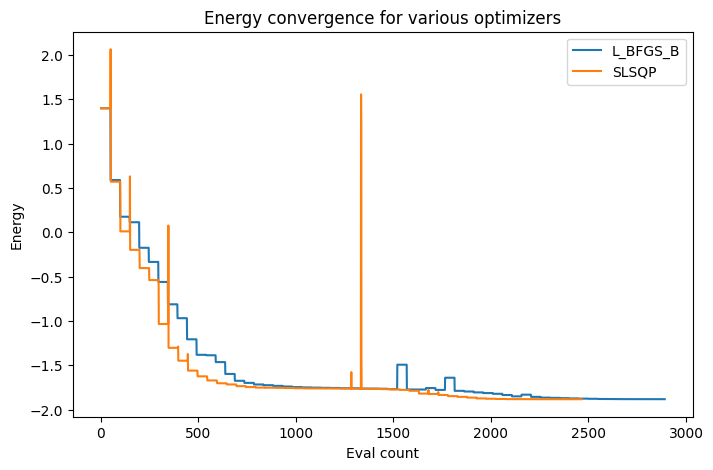

In [17]:
import pylab

converge_cnts, converge_vals = vqe_convergence(qc)
pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');

In [23]:
from qiskit.algorithms.minimum_eigensolvers import VQE
from qiskit.primitives import Estimator
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SLSQP
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.mappers import JordanWignerMapper, QubitConverter, ParityMapper
from qiskit_nature.units import DistanceUnit
from qiskit.utils import algorithm_globals


def VQE_fitness(qc: qiskit.QuantumCircuit):

    driver = PySCFDriver(
        atom="H 0 0 0; H 0 0 0.7",
        basis="631g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )
    problem = driver.run()
    hamiltonian = problem.hamiltonian.second_q_op()

    optimizer = SLSQP(maxiter=40)
    estimator = Estimator()
    algorithm_globals.random_seed = 50
    
    mapper=JordanWignerMapper()
    qubit_converter = QubitConverter(mapper)
    qubit_op = qubit_converter.convert(hamiltonian)
    vqe = VQE(estimator = estimator, ansatz = qc, optimizer=optimizer)
    ene = vqe.compute_minimum_eigenvalue(qubit_op).eigenvalue
    print(ene)
    return ene
print(ene_vqe)
def thres(GA_eigenvalue):
    if abs(GA_eigenvalue - ene_vqe) < 0.01:
        return True
    return False


-1.8820888154393793


Main algorithm, includes: init population, selection, crossover, mutate.

In [30]:
params = {'depth': 3,
          'num_circuit': 8,  # Must mod 8 = 0
          'num_generation': 6,
          'num_qubits': 8,
          'threshold': thres,
          'prob_mutate': 0.1}

env = environment.EEnvironment(
    params,
    fitness_func = VQE_fitness,
    selection_func = selection.elitist_selection,
    crossover_func= crossover.onepoint_crossover,
    mutate_func=mutate.bitflip_mutate,
    pool = qtm.constant.operations
)

#env.initialize_population()
env.evol() 

Step:   0%|          | 0/6 [00:00<?, ?it/s]

Initialize population ...
overwrite output file: /tmp/tmpqyzy2stm.log
-1.0058334910090558
overwrite output file: /tmp/tmpd82u6xi4.log
-1.0058334675516878
overwrite output file: /tmp/tmpj99beaki.log
-1.2346266113926458
overwrite output file: /tmp/tmprcpvfj_j.log
-1.2346266114312927
overwrite output file: /tmp/tmp57dtlbqe.log
-1.5042476452482285
overwrite output file: /tmp/tmpk560ifq0.log
-1.504247645386609
overwrite output file: /tmp/tmpm6e40b8w.log
-0.2371803057899364
overwrite output file: /tmp/tmpe9upif22.log
-0.23717279882981163
overwrite output file: /tmp/tmpj_oa_45c.log
-1.8820900923481112
overwrite output file: /tmp/tmp93evnbgq.log
-1.8820905715994738
overwrite output file: /tmp/tmpjjpa4plx.log
-1.8820902393861234
overwrite output file: /tmp/tmp5r38as7b.log
-1.882090524673584
overwrite output file: /tmp/tmpe22syola.log
-1.7575535789072385
overwrite output file: /tmp/tmp_nsaspo3.log
-1.7575535788479482
overwrite output file: /tmp/tmpajcppzbi.log
-0.23815945753805418
overwrite outp

Step:  17%|█▋        | 1/6 [00:57<04:49, 57.91s/it]

-0.9182549522060942
End evol progress, best score ever: -1.882090414256846


Test best candidate again

In [31]:
qc = env.best_candidate.qc
#env.plot()
print(VQE_fitness(qc))

overwrite output file: /tmp/tmppc6maxpd.log
-1.882090508936425
-1.882090508936425


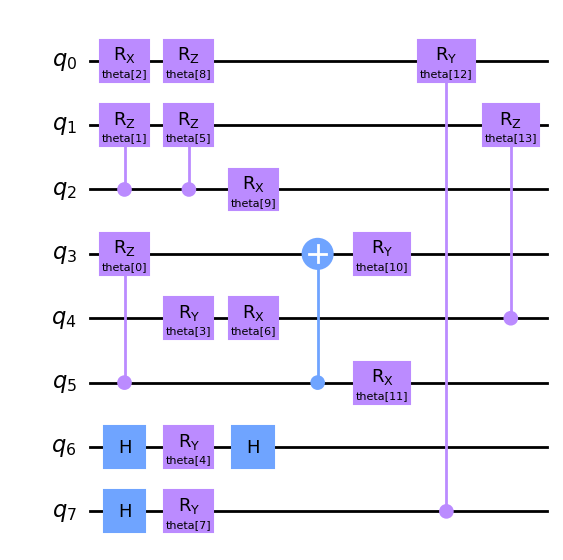

In [32]:
qc.draw('mpl')

Optimizer: L_BFGS_B        -1.882090605507282
Optimizer: SLSQP        -1.882090588500393


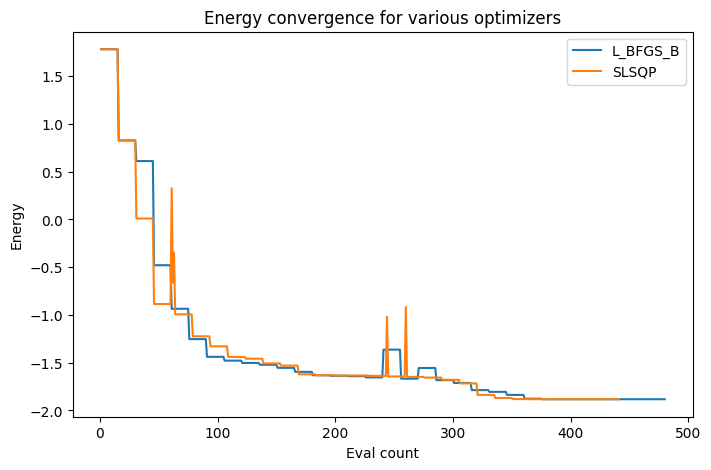

In [33]:
converge_cnts, converge_vals = vqe_convergence(qc)

pylab.rcParams['figure.figsize'] = (8, 5)
for i, optimizer in enumerate(optimizers):
    pylab.plot(converge_cnts[i], converge_vals[i], label=type(optimizer).__name__)
pylab.xlabel('Eval count')
pylab.ylabel('Energy')
pylab.title('Energy convergence for various optimizers')
pylab.legend(loc='upper right');